# Figures: The three-year evolution of Germany's digital therapeutics reimbursement program and its path forward  

### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.font_manager as font_manager
import numpy as np

### Loading the data

In [2]:
file_path = 'data/DiGA_26012024.csv'
diga_data = pd.read_csv(file_path)

### Preprocessing

In [3]:
# Make sure the date columns are in datetime format
diga_data['End_of_listing_date'] = pd.to_datetime(diga_data['End_of_listing_date'], format='%d.%m.%Y',  errors='coerce')
diga_data['start_date_testphase'] = pd.to_datetime(diga_data['start_date_testphase'], format='%d.%m.%Y',  errors='coerce')
diga_data['end_date_testphase'] = pd.to_datetime(diga_data['end_date_testphase'], format='%d.%m.%Y',  errors='coerce')
# remove tangling spaces from values 
diga_data['temp_listig_start'] = diga_data['temp_listig_start'].str.replace(' ', '')
diga_data['permanent_listing_start'] = diga_data['permanent_listing_start'].str.replace(' ', '')
diga_data['temp_listig_start'] = pd.to_datetime(diga_data['temp_listig_start'], format='%d.%m.%Y',  errors='coerce')
diga_data['permanent_listing_start'] = pd.to_datetime(diga_data['permanent_listing_start'], format='%d.%m.%Y',  errors='coerce')


## Number of DiGAs in different stages of the regulatory process over time 

In [4]:
# set the max date to end of January 2024
max_date = pd.Timestamp('31.01.2024')

# Create a date range covering all dates in the dataset
min_date = min(diga_data['temp_listig_start'].min(), diga_data['permanent_listing_start'].min())
all_dates = pd.date_range(start=min_date, end=max_date,freq='M')

# Initialize a DataFrame to store counts for each date
date_counts = pd.DataFrame(index=all_dates)

# Define the logic for counting DiGAs in each category
def count_digas(date):
    temp_listed = ((diga_data['temp_listig_start'].dt.to_period('M') <= date.to_period('M')) & 
                   ((diga_data['permanent_listing_start'].dt.to_period('M') > date.to_period('M')) | pd.isna(diga_data['permanent_listing_start'])) & 
                   pd.isna(diga_data['End_of_listing_date'])).sum()

    perm_listed = ((diga_data['permanent_listing_start'].dt.to_period('M') <= date.to_period('M')) & 
                   (pd.isna(diga_data['End_of_listing_date']) | (diga_data['End_of_listing_date'].dt.to_period('M') > date.to_period('M')))).sum()

    discontinued = (diga_data['End_of_listing_date'].dt.to_period('M') <= date.to_period('M')).sum()

    if date == max_date:
        # Filter the DataFrame based on the criteria
        temp_listed_criteria = (
            (diga_data['temp_listig_start'].dt.to_period('M') <= date.to_period('M')) & 
            ((diga_data['permanent_listing_start'].dt.to_period('M') > date.to_period('M')) | pd.isna(diga_data['permanent_listing_start'])) & 
            pd.isna(diga_data['End_of_listing_date'])
        )

    return temp_listed, perm_listed, discontinued

# Apply the counting logic to each date
date_counts[['Temporarily_Listed', 'Permanently_Listed', 'Discontinued']] = [count_digas(d) for d in all_dates]

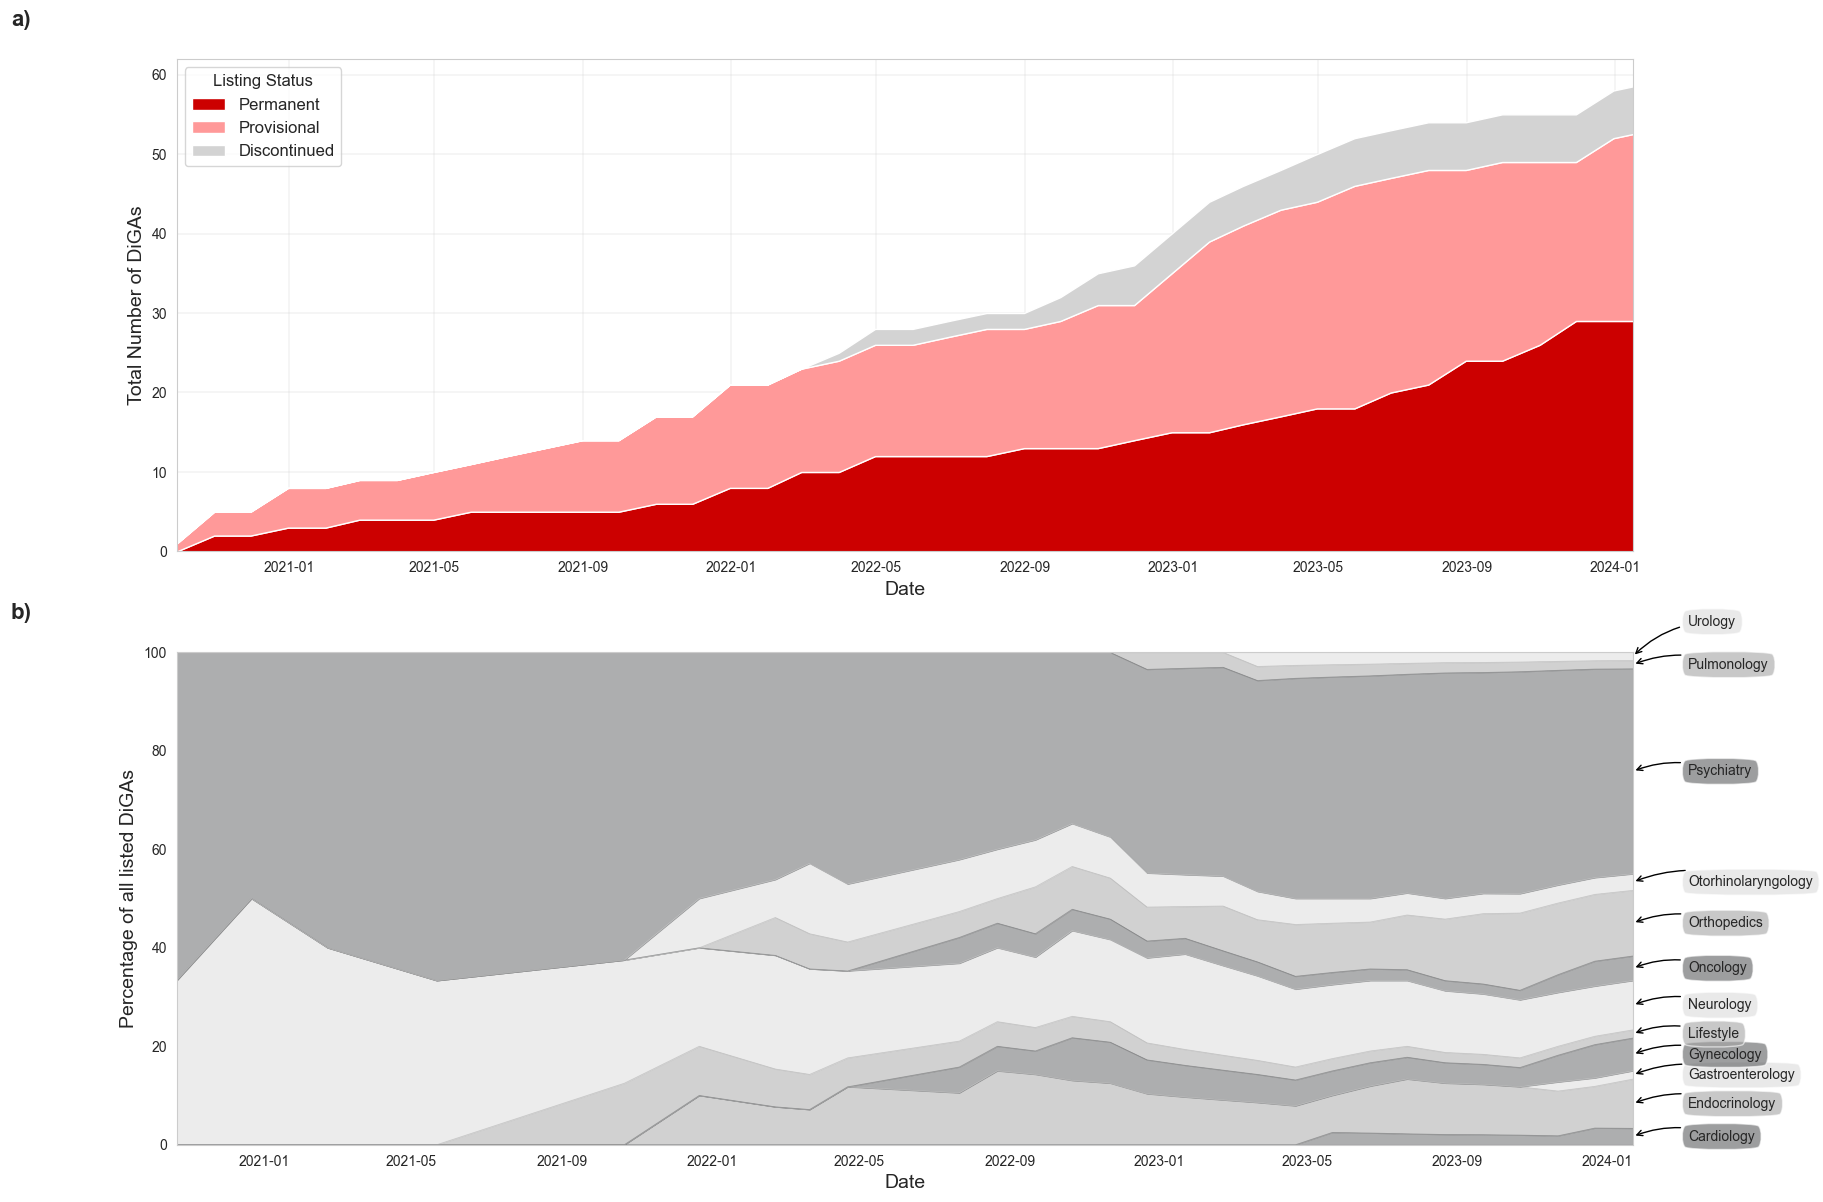

In [5]:
# Custom color maps and style settings
scientific_cmap = ["#5C5E60", "#A4A4A4", "#DBDBDB", "#5C5E60", "#A4A4A4", "#DBDBDB","#5C5E60", "#A4A4A4", "#DBDBDB","#5C5E60", "#A4A4A4", "#DBDBDB"]
custom_cmap = ListedColormap(scientific_cmap)

custom_palette_corrected = ["#cc0000", "#ff9999", "#d3d3d3"]

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.serif'] = 'Helvetica'
sns.set_style("whitegrid")

# First Plot Preparation: Cumulative number of DiGAs
diga_data_non_discontinued = diga_data[diga_data["Listing_discontinued"] == 0].copy()
diga_data_non_discontinued['listing_date'] = diga_data_non_discontinued['permanent_listing_start'].combine_first(diga_data_non_discontinued['temp_listig_start'])
diga_data_non_discontinued['listing_date'] = pd.to_datetime(diga_data_non_discontinued['listing_date'])
diga_data_non_discontinued['year_month'] = diga_data_non_discontinued['listing_date'].dt.to_period('M').dt.to_timestamp()
specialties_expanded = diga_data_non_discontinued['specialty_rough_e'].str.split(';').apply(pd.Series, 1).stack()
specialties_expanded.index = specialties_expanded.index.droplevel(-1)
specialties_expanded.name = 'specialty'
df = diga_data_non_discontinued.join(specialties_expanded)
grouped_df = df.groupby(['year_month', 'specialty']).size().unstack(fill_value=0)
cumulative_df = grouped_df.cumsum()

# Create a figure with two subplots
fig, (ax2, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(18, 12))
# Adding subplot labels
ax1.text(-0.1, 1.1, 'b)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax2.text(-0.1, 1.1, 'a)', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')


# Calculating the percentage of total DiGAs for each specialty in each month
percentage_df = cumulative_df.divide(cumulative_df.sum(axis=1), axis=0) * 100

# Plotting
percentage_df.plot(kind='area', stacked=True, colormap=custom_cmap, ax=ax1, alpha=0.5, linewidth=0.5)
ax1.set_xlabel('Date', fontsize=14)
ax1.set_ylabel('Percentage of all listed DiGAs', fontsize=14)
ax1.set_ylim([0, 100])
ax1.tick_params(axis='x', rotation=0)
ax1.set_xlim([diga_data_non_discontinued['year_month'].min(), diga_data_non_discontinued['year_month'].max()])
ax1.legend().remove()
ax1.grid(False)

# Calculate the positions for annotations
# This will store the y-value for the last entry (right edge of the plot) of each specialty
y_positions = percentage_df.iloc[-1].cumsum() - (percentage_df.iloc[-1] / 2)

# Define a variable to adjust the position of the last label if needed
last_label_adjustment = 0
# Define a threshold for vertical distance between labels to avoid overlap
threshold = 3 
adjust_value = 5


# add the annotations to the plot
for i, (specialty, y_pos) in enumerate(y_positions.items()):
    # Special case for the last label to avoid overlap
    if i == len(y_positions) - 1:  # Check if it's the last label
        last_label_adjustment = 5  # Adjust this value as needed

    # Determine the color for the annotation from the colormap
    color = custom_cmap(i / len(y_positions))
    
    # Horizontal position for annotation (slightly past the last date for space)
    x_pos = percentage_df.index[-1]

    # Vertical adjustment if the labels overlap
    vertical_adjustment = 0
    if i > 0 and abs(y_positions[i] - y_positions[i - 1]) < threshold:
        vertical_adjustment = adjust_value  # Determine the adjust_value

    # Annotation text and arrow
    ax1.annotate(specialty, 
                 xy=(x_pos, y_pos + last_label_adjustment - vertical_adjustment), 
                 xycoords='data',
                 xytext=(40, +last_label_adjustment * 5),  # Adjust text position for the last label
                 textcoords='offset points',
                 va='center', ha='left', fontsize=10,
                 bbox=dict(boxstyle="round4,pad=.5", fc=color, alpha=0.6),
                 arrowprops=dict(arrowstyle="->", color='black', connectionstyle="arc3,rad=.2"))

# Adjust the subplot's right margin to make space for the annotations
plt.subplots_adjust(right=0.75)


# Second Plot: Total number of DiGA by listing status
ax2.stackplot(date_counts.index, date_counts['Permanently_Listed'], date_counts['Temporarily_Listed'], date_counts['Discontinued'], labels=['Permanent', 'Provisional', 'Discontinued'], colors=custom_palette_corrected)
ax2.set_xlabel('Date', fontsize=14)
ax2.set_ylabel('Total Number of DiGAs', fontsize=14)
ax2.set_xlim([date_counts.index.min(), pd.Timestamp('16.01.2024')])
legend = ax2.legend(loc='upper left', fontsize=12, title='Listing Status', title_fontsize=12)
ax2.grid(True, linestyle='-', linewidth=0.3, color='lightgray')

# Adjust layout and save figure
plt.tight_layout()
plt.savefig('figures/DiGA_development.png', dpi=300)
plt.show()


__________________________

## DiGA prescriptions and proportion of female users by indication group and year (2022 and 2023) 

### Loading the usage data

In [6]:
diga_usage = pd.read_csv('data/DiGA_usage.csv', parse_dates=True)

### Preprocessing

In [7]:
# remove the last row 
diga_usage = diga_usage[:-1]

# sort the data by the highest to the lowest value for Anzahl_DiGA_2022
diga_usage = diga_usage.sort_values(by=['Anzahl_DiGA_2022'], ascending=False)

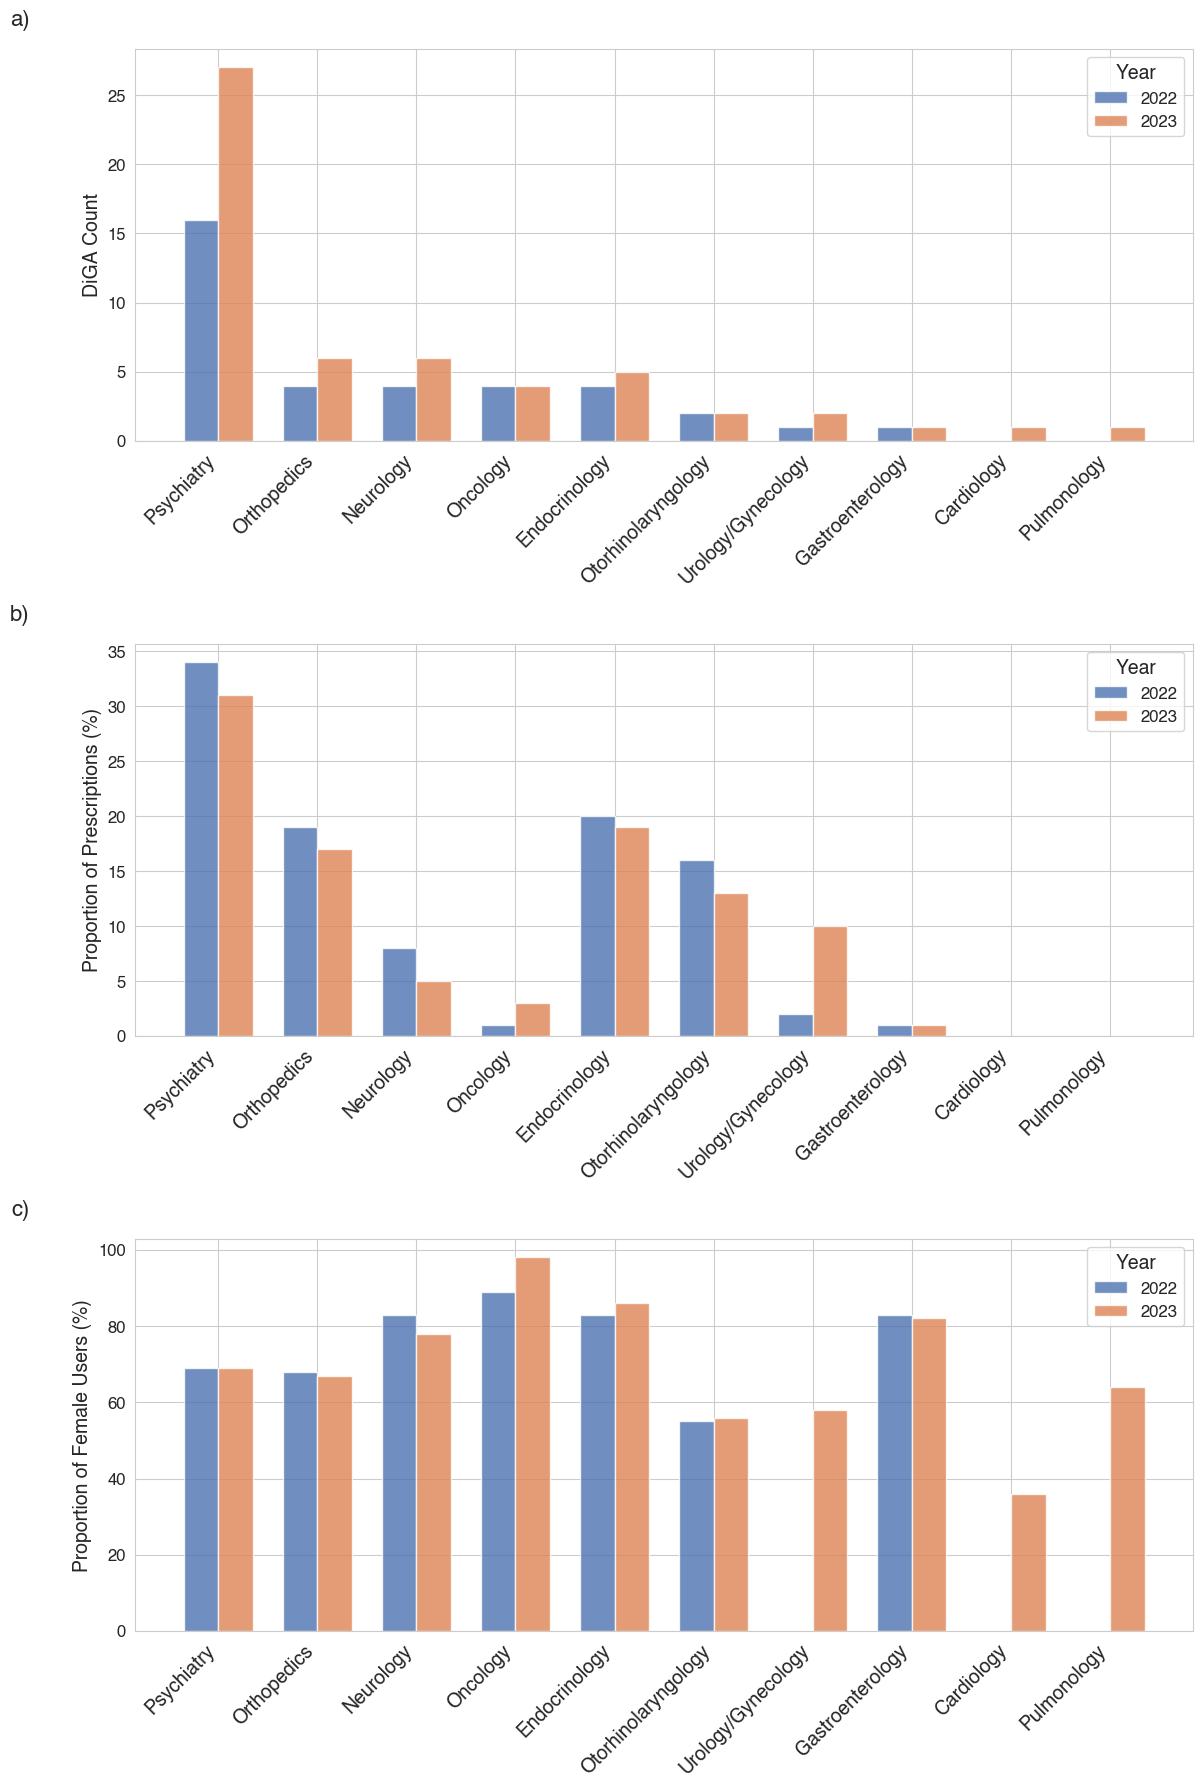

In [9]:
sns.set_style("whitegrid")
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'

# Setting the width for the bars in the bar plot
bar_width = 0.35

# Calculating positions for each group of bars
n_groups = len(diga_usage)
index = np.arange(n_groups)

# Creating the plots with 2022 and 2023 values next to each other
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))

# Plot for Anzahl_DiGA (Number of DiGA)
axes[0].bar(index, diga_usage['Anzahl_DiGA_2022'], bar_width, label='2022', alpha=0.8, color='#4c72b0')
axes[0].bar(index + bar_width, diga_usage['Anzahl_DiGA_2023'], bar_width, label='2023', alpha=0.8, color='#dd8452')
axes[0].set_xticks(index + bar_width / 2)
axes[0].set_xticklabels(diga_usage['Indication_group_e'], rotation=45, ha="right", fontsize=14)
axes[0].set_ylabel('DiGA Count', fontsize=14)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].legend(title='Year', loc='upper right', fontsize=12, title_fontsize=14)
axes[0].text(-0.1, 1.1, 'a)', transform=axes[0].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Plot for Anteil_Abgaben (Proportion of Prescriptions)
axes[1].bar(index, diga_usage['Anteil_Abgaben_2022'], bar_width, label='2022', alpha=0.8, color='#4c72b0')
axes[1].bar(index + bar_width, diga_usage['Anteil_an_Gesamteinlösungen_2023'], bar_width, label='2023', alpha=0.8, color='#dd8452')
axes[1].set_xticks(index + bar_width / 2)
axes[1].set_xticklabels(diga_usage['Indication_group_e'], rotation=45, ha="right", fontsize=14)
axes[1].set_ylabel('Proportion of Prescriptions (%)', fontsize=14)
axes[1].legend(title='Year', loc='upper right', fontsize=12, title_fontsize=14)
axes[1].tick_params(axis='y', labelsize=12)
axes[1].text(-0.1, 1.1, 'b)', transform=axes[1].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Plot for Anteil_Frauen (Proportion of Women)
axes[2].bar(index, diga_usage['Anteil_Frauen_2022'], bar_width, label='2022', alpha=0.8, color='#4c72b0')
axes[2].bar(index + bar_width, diga_usage['Anteil_Frauen_2023'], bar_width, label='2023', alpha=0.8, color='#dd8452')
axes[2].set_xticks(index + bar_width / 2)
axes[2].set_xticklabels(diga_usage['Indication_group_e'], rotation=45, ha="right", fontsize=14)
axes[2].set_ylabel('Proportion of Female Users (%)', fontsize=14)
axes[2].legend(title='Year', loc='upper right', fontsize=12, title_fontsize=14)
axes[2].tick_params(axis='y', labelsize=12)
axes[2].text(-0.1, 1.1, 'c)', transform=axes[2].transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig('figures/DiGA_usage.png', dpi=300)

# Show the plot
plt.show()

__________________________

## Initial and final prices of permanently listed DiGAs post price negotiation

In [10]:
# take the data from the column ICD_level_1_e and convert each entry to a list
diga_data['ICD_level_1_e'] = diga_data['ICD_level_1_e'].str.split(';')

# create a new column with the first entry of the list
diga_data['ICD_level_1_e_0'] = diga_data['ICD_level_1_e'].str[0]

# take the data from the column specialty_rough_e and convert each entry to a list
diga_data['specialty_rough_e'] = diga_data['specialty_rough_e'].str.split(';')

# create a new column with the first entry of the list
diga_data['specialty_rough_e_0'] = diga_data['specialty_rough_e'].str[0]


In [11]:
# fill all missing values from Starting_price_in_euro and fill by Price_in_euro
diga_data['Starting_price_in_euro'].fillna(diga_data['Price_in_euro'], inplace=True)

# remove levidex row from the data set (wrong format and anyway not a permanently listed DiGA)
diga_data = diga_data[diga_data['App_name'] != 'levidex']

diga_data['Starting_price_in_euro'] = diga_data['Starting_price_in_euro'].str.replace('€', '')
diga_data['Starting_price_in_euro'] = diga_data['Starting_price_in_euro'].str.replace(',', '.').astype(float)

diga_data['Price_in_euro'] = diga_data['Price_in_euro'].str.replace('€', '')
diga_data['Price_in_euro'] = diga_data['Price_in_euro'].str.replace(',', '.').astype(float)

In [12]:
diga_data["Listing_year"] = pd.to_datetime(diga_data["start_date_testphase"]).dt.year

In [13]:
# Correcting the approach to handle NaN values and filter only permanently listed DiGAs
diga_data['Starting_price_in_euro'].fillna(diga_data['Price_in_euro'], inplace=True)
permanent_digas_corrected = diga_data[diga_data['Permanent_listing'] == 1]


specialty_list = permanent_digas_corrected['specialty_rough_e_0'].unique()

# create the subset of permanently listed DiGAs with completed negotiation
negotiation_completed = permanent_digas_corrected[permanent_digas_corrected['negotiation_completed'] == 1]

/var/folders/j0/gd9db9l10k5grhsvfgxwyll00000gn/T/ipykernel_88579/1317256114.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negotiation_completed['Listing_year'].fillna(2024, inplace=True)
/var/folders/j0/gd9db9l10k5grhsvfgxwyll00000gn/T/ipykernel_88579/1317256114.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negotiation_completed['Listing_year'] = negotiation_completed['Listing_year'].astype(int)


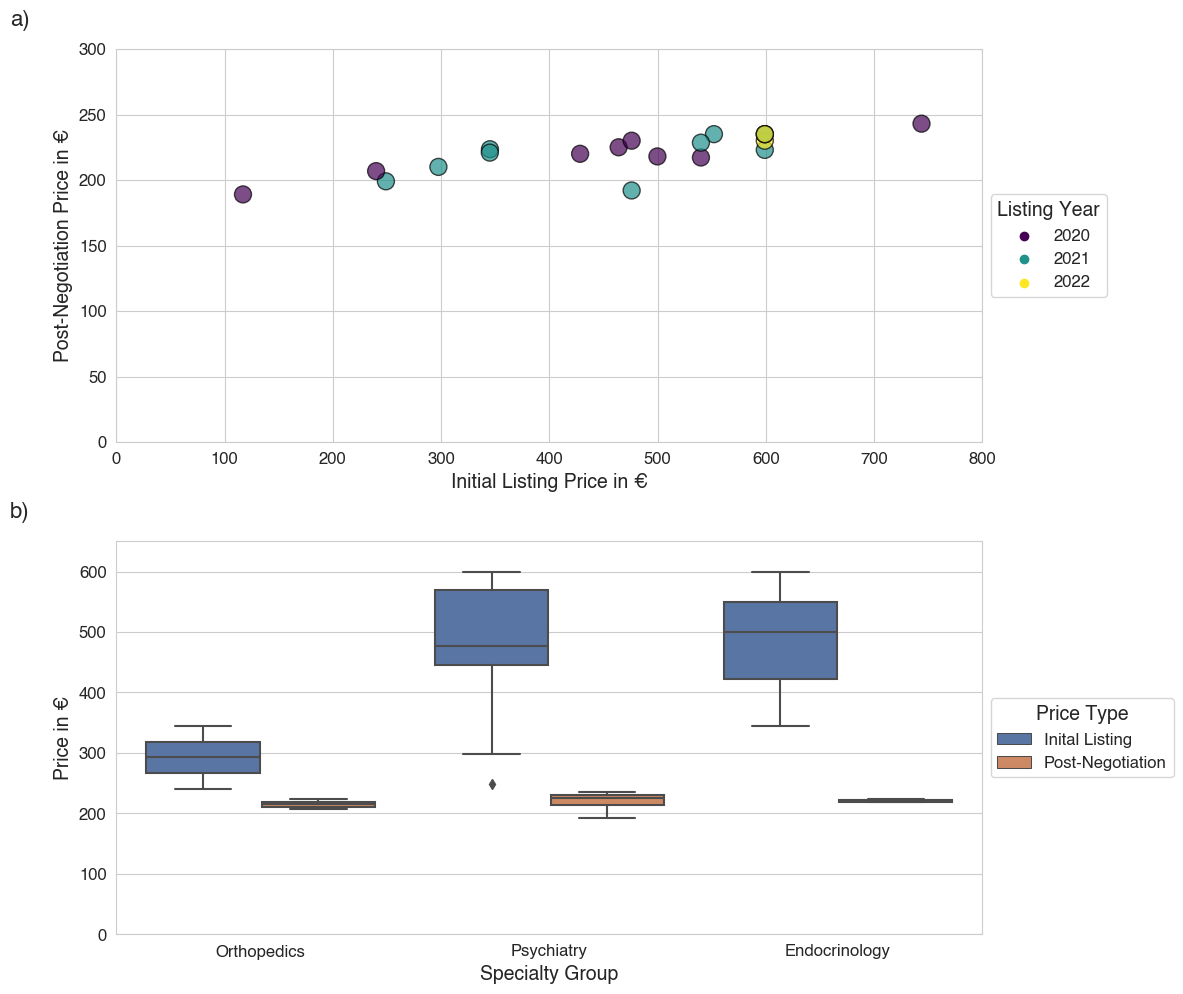

In [14]:
# Set the overall figure size
plt.figure(figsize=(12, 10))

# Subplot a) Scatter Plot
ax1 = plt.subplot(2, 1, 1)

# Convert NaN to 2024 in 'Listing_year' and convert the column to integers
negotiation_completed['Listing_year'].fillna(2024, inplace=True)
negotiation_completed['Listing_year'] = negotiation_completed['Listing_year'].astype(int)

# Setting styles for the scatter plot
sns.set_style("whitegrid")
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'

# Create the scatter plot
sns.scatterplot(x='Starting_price_in_euro', y='Price_in_euro', data=negotiation_completed,
                hue='Listing_year', palette='viridis', s=150, alpha=0.7, edgecolor='k')

# Adjusting labels and legend for scatter plot
ax1.set_xlabel('Initial Listing Price in €', fontsize=14)
ax1.set_ylabel('Post-Negotiation Price in €', fontsize=14)
ax1.tick_params(labelsize=12)
ax1.legend(title='Listing Year', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, title_fontsize=14)
ax1.set_xlim(0, 800)
ax1.set_ylim(0, 300)
ax1.text(-0.1, 1.1, 'a)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Subplot b) Side-by-side Box plots for Starting and Current Price
ax2 = plt.subplot(2, 1, 2)

# Create a subframe for box plots
specialty_counts = negotiation_completed.groupby('specialty_rough_e_0').filter(lambda x: x['specialty_rough_e_0'].count() > 1)

# Reshape the data to long format
melted_data = specialty_counts.melt(id_vars='specialty_rough_e_0', value_vars=['Starting_price_in_euro', 'Price_in_euro'], 
                                    var_name='Price_Type', value_name='Price')

# Create the box plot
sns.boxplot(x='specialty_rough_e_0', y='Price', hue='Price_Type', data=melted_data, palette="deep")

# Improve plot aesthetics
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
ax2.set_xlabel('Specialty Group', fontsize=14)
ax2.set_ylabel('Price in €', fontsize=14)
# start y axis at 0
ax2.set_ylim(0, 650)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax2.legend(title='Price Type', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, title_fontsize=14)
# change legend labels
plt.gca().get_legend().get_texts()[0].set_text('Inital Listing')
plt.gca().get_legend().get_texts()[1].set_text('Post-Negotiation')
ax2.text(-0.1, 1.1, 'b)', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Adjust layout and display the combined figure
plt.tight_layout()

# Save figure
plt.savefig('figures/DiGA_pricing.png', dpi=300)

plt.show()

__________________________

## Supplementary figures

### Specialties of DiGAs from Manufacturers with multiple DiGAs on the market 

In [15]:
# Calculate the value counts for each manufacturer 
company_counts = diga_data['Company_name'].value_counts()
# for all manufacturers with more than 1 DiGA investigate the number of DiGAs per specialty
# create a list of all manufacturers with more than 1 DiGA
company_counts_multiple_diga = company_counts[company_counts > 1]
company_counts_multiple_diga = company_counts_multiple_diga.index.tolist()

# create a new dataframe with only the manufacturers with more than 1 DiGA
diga_data_company_counts = diga_data[diga_data['Company_name'].isin(company_counts_multiple_diga)]
# sort the dataframe by manufacturer with the highest number of DiGAs
diga_data_company_counts = diga_data_company_counts.sort_values(by=['Company_name'], ascending=True)

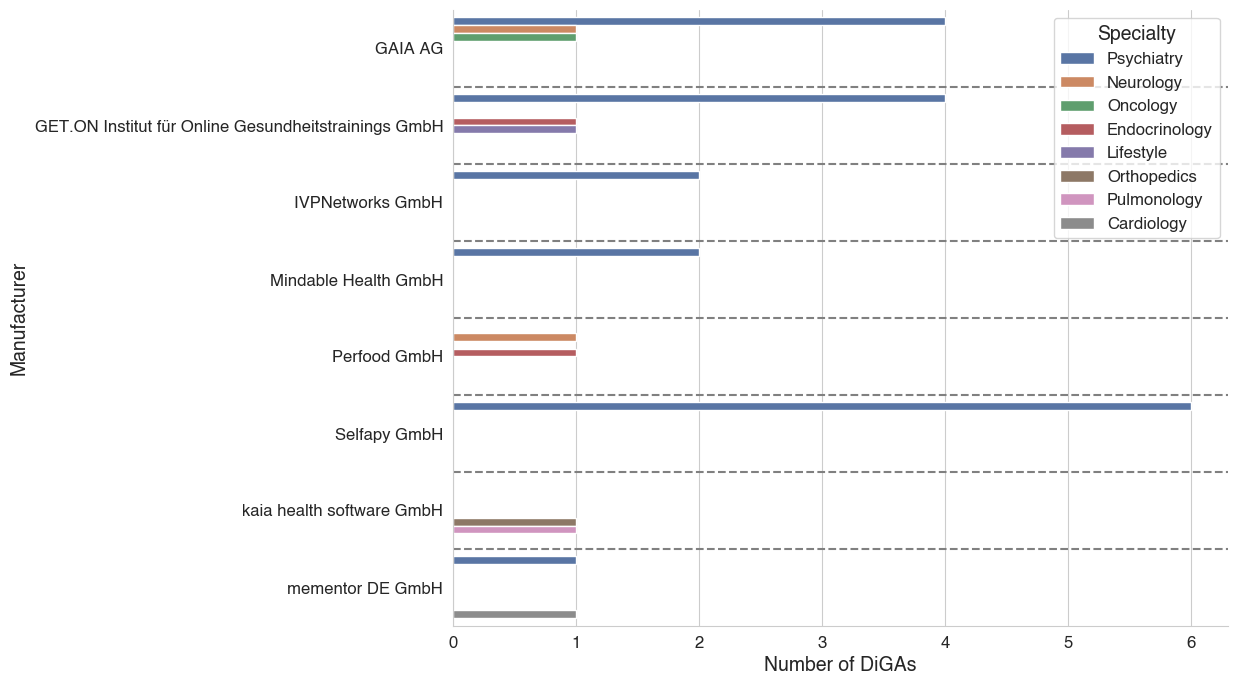

In [16]:
# create a plot with the number of DiGAs per specialty for each manufacturer
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'

sns.countplot(y='Company_name', hue='specialty_rough_e_0', data=diga_data_company_counts, palette='deep')
# add a line horisonally to separate the manufacturers
plt.axhline(y=0.5, color='gray', linestyle='--')
plt.axhline(y=1.5, color='gray', linestyle='--')
plt.axhline(y=2.5, color='gray', linestyle='--')
plt.axhline(y=3.5, color='gray', linestyle='--')
plt.axhline(y=4.5, color='gray', linestyle='--')
plt.axhline(y=5.5, color='gray', linestyle='--')
plt.axhline(y=6.5, color='gray', linestyle='--')
plt.xlabel('Number of DiGAs', fontsize=14)
plt.ylabel('Manufacturer', fontsize=14)
plt.legend(title='Specialty', loc='upper right')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Specialty', loc='upper right', fontsize=12, title_fontsize=14)
sns.despine()
# Save figure
plt.savefig('figures/DiGA_manufacturer.png', dpi=300)
plt.show()

### Initial DiGA listing price development since DiGA initiation in 2020 

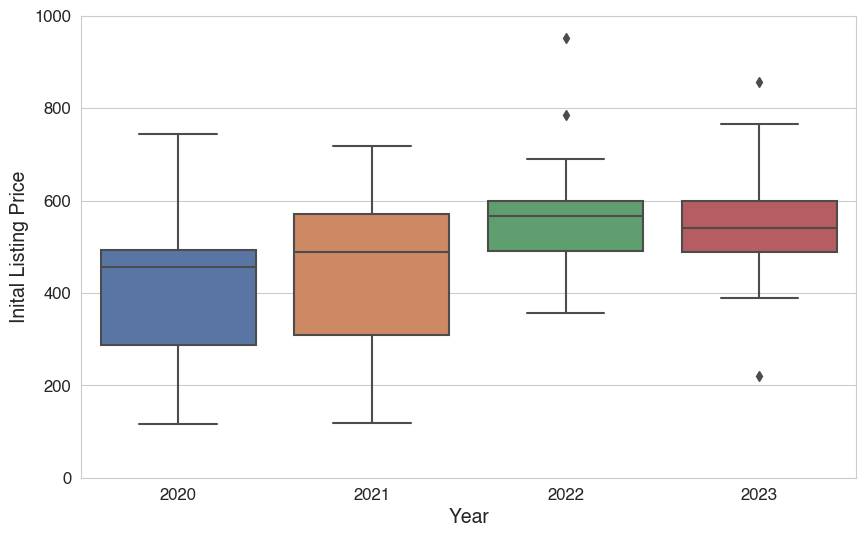

In [17]:
# Create the box plot
plt.figure(figsize=(10, 6))
# Setting styles for the scatter plot
sns.set_style("whitegrid")
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'
sns.boxplot(x='Listing_year', y='Starting_price_in_euro', data=diga_data[diga_data['Listing_year'] != 2024], palette='deep')
# plt.title('Box Plot of DiGA Application Prices (2020-2023)')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Inital Listing Price', fontsize=14)
# start y axis at 0
plt.ylim(0, 1000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# Save figure
plt.savefig('figures/DiGA_price_boxplot.png', dpi=300)
plt.show()
